In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import zipfile

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# Descargar dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
urllib.request.urlretrieve(url, "smsspamcollection.zip")

# Leer dataset
with zipfile.ZipFile("smsspamcollection.zip") as z:
    with z.open("SMSSpamCollection") as f:
        df = pd.read_csv(f, sep="\t", names=["label", "message"])

# Verificar
print(df.head())
print(df["label"].value_counts())


  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
label
ham     4825
spam     747
Name: count, dtype: int64


In [10]:
# Convertir labels a numérico
df["label"] = df["label"].map({"ham":0, "spam":1})

# Longitud del mensaje como característica adicional
df["message_length"] = df["message"].apply(len)

# Vectorización TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(df["message"])

# Combinar TF-IDF con longitud del mensaje
from scipy.sparse import hstack
X = hstack([X_tfidf, df["message_length"].values.reshape(-1,1)])
y = df["label"].values

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [11]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)


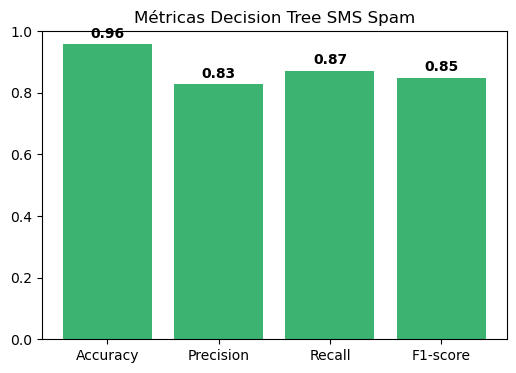

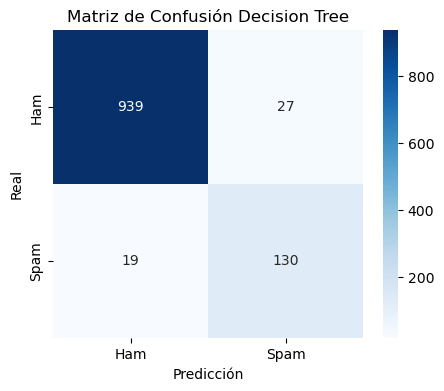

In [12]:
# Métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-score": f1}

plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color="mediumseagreen")
plt.ylim(0,1)
plt.title("Métricas Decision Tree SMS Spam")
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center", fontweight="bold")
plt.show()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham","Spam"], yticklabels=["Ham","Spam"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión Decision Tree")
plt.show()


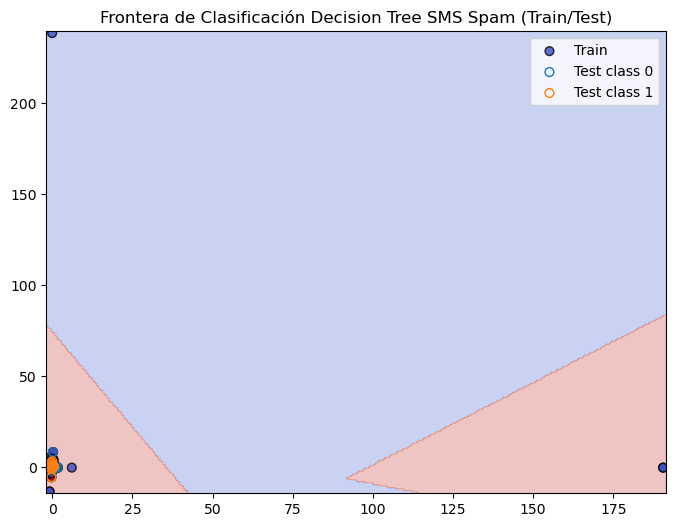

In [13]:
# Escalado y PCA
scaler = StandardScaler(with_mean=False)  # necesario para sparse matrices
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled.toarray())
X_test_pca = pca.transform(X_test_scaled.toarray())

# Crear malla de puntos para la frontera
x_min, x_max = X_train_pca[:,0].min()-1, X_train_pca[:,0].max()+1
y_min, y_max = X_train_pca[:,1].min()-1, X_train_pca[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
Z = dt.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")

# Colores para clases: 0=Ham, 1=Spam
colors = np.array(["#1f77b4", "#ff7f0e"])

# Train sólidos
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, cmap="coolwarm",
            s=40, alpha=0.8, edgecolor="k", label="Train")

# Test hueco: solo borde, color según clase
for cls in np.unique(y_test):
    idx = y_test == cls
    plt.scatter(X_test_pca[idx,0], X_test_pca[idx,1],
                facecolors='none', edgecolors=colors[cls],
                s=40, label=f"Test class {cls}")

plt.title("Frontera de Clasificación Decision Tree SMS Spam (Train/Test)")
plt.legend()
plt.show()

